<a href="https://colab.research.google.com/github/williamteles/Regression_Data_Mining/blob/main/Regression_Minera%C3%A7%C3%A3o_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Classe para facilitar a fazer os print com cores
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# __Instalando dependências e importando__

In [2]:
try:
  from pycaret.regression import * 
  import pandas as pd
  import numpy as np
  from sklearn.model_selection import StratifiedShuffleSplit
  from sklearn.model_selection import ShuffleSplit
  from sklearn.metrics import mean_squared_error

except ImportError:
  print(f'{bcolors.FAIL}Instalando dependências.{bcolors.ENDC}')
  print(f'{bcolors.FAIL}A EXECUÇÃO SERÁ PARADA! Por favor, execute novamente depois de parada.{bcolors.ENDC}\n')
  # !pip install pycaret &> /dev/null
  !pip install -q pycaret
  !pip install -q tune-sklearn ray[tune]
  !pip install -q scikit-optimize
  import os
  os.kill(os.getpid(), 9)

# __Lendo e analisando o dataset__

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00618/Steel_industry_data.csv"
df = pd.read_csv(url, delimiter=',')
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [4]:
# Removendo coluna de data
df.drop(df.columns[0], axis=1, inplace=True)

In [5]:
# Checando o shape dos dados
df.shape

(35040, 10)

In [6]:
# Checando se existe dados nulos
df.isnull().sum()

Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [7]:
# Checando se há dados duplicados
df.duplicated().sum()

81

In [8]:
# Checando de se esses dados duplicados se tratam de linhas inteiras duplicadas
df.eq(0).all(axis=1).any()

False

In [9]:
# Checando o tipo de cada feature
df.dtypes

Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
dtype: object

## __Codificando atributos categóricos__

In [10]:
def replace_categories(data, cols):

  for col in cols:
    ordered_labels = df[col].unique()

    ordinal_label = {k: i for i, k in enumerate(ordered_labels)}
    print(col, ordinal_label)
    print()

    # usando o dic para trocar os categorias por inteiros
    data[col] = data[col].map(ordinal_label)

In [11]:
# Extraindo as colunas categóricas
categ_columns = df.select_dtypes(include=['object']).columns

# Codificando as mesmas
replace_categories(df, categ_columns)

WeekStatus {'Weekday': 0, 'Weekend': 1}

Day_of_week {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

Load_Type {'Light_Load': 0, 'Medium_Load': 1, 'Maximum_Load': 2}



## __Analisando dados estatísticos descritivos dos atributos__

In [12]:
df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000,0.284932,2.991781,0.691781
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317,0.451388,2.003433,0.792658
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000,0.000000,1.000000,0.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000,0.000000,3.000000,0.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000,1.000000,5.000000,1.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000,1.000000,6.000000,2.000000


## __Limitando Anomalias das colunas numéricas__

In [13]:
# Obtendo a lista de colunas numéricas ao subtrair o set das colunas 
#   com o set das colunas categoricas
num_columns = set(df.columns) - set(categ_columns)

# Removendo a coluna target da regressão da lista
num_columns.discard('Usage_kWh')

num_columns


{'CO2(tCO2)',
 'Lagging_Current_Power_Factor',
 'Lagging_Current_Reactive.Power_kVarh',
 'Leading_Current_Power_Factor',
 'Leading_Current_Reactive_Power_kVarh',
 'NSM'}

In [14]:
# Função para limitar as anomalias dos dados
def limitar_anomalias(data, anomalia_cols):
  for col in anomalia_cols:
    q25, q75 = np.percentile(data[col], 25), np.percentile(data[col], 75)

    iiq = q75 - q25

    print(f'{bcolors.BOLD}Percentis da coluna {bcolors.ENDC}', end='')
    print(f'{bcolors.OKCYAN}{col}{bcolors.ENDC}: ', end='')
    print(f'25% = {bcolors.WARNING}{q25:.3f}{bcolors.ENDC}, ', end='')
    print(f'75% = {bcolors.WARNING}{q75:.3f}{bcolors.ENDC}, ', end='')
    print(f'IIQ = {bcolors.WARNING}{iiq:.3f}{bcolors.ENDC}')
    corte = iiq * 1.5

    inferior, superior = q25 - corte, q75 + corte

    anomalias = [x for x in data[col] if x < inferior or x > superior]

    print(f'{bcolors.BOLD}Outliers Identificados{bcolors.ENDC}: ', end='')
    print(f'{bcolors.WARNING}{len(anomalias)}{bcolors.ENDC}')

    print(bcolors.OKGREEN + '#' * 100 + bcolors.ENDC + '\n')

    data[col] = np.clip(data[col], inferior, superior)
  
  return data

In [15]:
# Chamando a função
df2 = limitar_anomalias(df, num_columns)

Percentis da coluna Leading_Current_Power_Factor: 25% = 99.700, 75% = 100.000, IIQ = 0.300
Outliers Identificados: 8327
####################################################################################################

Percentis da coluna NSM: 25% = 21375.000, 75% = 64125.000, IIQ = 42750.000
Outliers Identificados: 0
####################################################################################################

Percentis da coluna Leading_Current_Reactive_Power_kVarh: 25% = 0.000, 75% = 2.090, IIQ = 2.090
Outliers Identificados: 7759
####################################################################################################

Percentis da coluna Lagging_Current_Power_Factor: 25% = 63.320, 75% = 99.023, IIQ = 35.703
Outliers Identificados: 1
####################################################################################################

Percentis da coluna Lagging_Current_Reactive.Power_kVarh: 25% = 2.300, 75% = 22.640, IIQ = 20.340
Outliers Identificados: 1059
##

In [16]:
# Reanalisando os dados estatísticos descritivos
df2.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,12.790640,1.304613,0.011392,80.578335,99.811411,42750.000000,0.284932,2.991781,0.691781
std,33.444380,15.577588,2.197324,0.015785,18.920207,0.319341,24940.534317,0.451388,2.003433,0.792658
min,0.000000,0.000000,0.000000,0.000000,9.766250,99.250000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000,0.000000,1.000000,0.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000,0.000000,3.000000,0.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000,1.000000,5.000000,1.000000
max,157.180000,53.150000,5.225000,0.050000,100.000000,100.000000,85500.000000,1.000000,6.000000,2.000000


# __Modelagem__

## __Separando os dados para treino e teste__

In [26]:
def split_train_test(df, target):
  msk = np.random.rand(len(df)) < 1 - target
  train = df[msk].copy()
  test  = df[~msk].copy()

  return train, test


In [27]:
train, test = split_train_test(df2, 0.30)

## __Incializando o PyCaret com dados de treino__

In [30]:
# Fazendo o setup do PyCaret
reg = setup(data=train, target='Usage_kWh', silent=True, verbose=False,
            fold_shuffle=True, fold=30)

## __Comparando os melhores modelos de regressão__

In [31]:
best = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.7691,4.6627,2.1362,0.9958,0.0908,0.0489,4.8560
et,Extra Trees Regressor,0.7869,4.7704,2.1599,0.9957,0.0926,0.0494,3.7230
lightgbm,Light Gradient Boosting Machine,1.0684,5.2036,2.2592,0.9953,0.1089,0.0780,0.1827
dt,Decision Tree Regressor,1.0296,7.3768,2.6861,0.9933,0.1026,0.0567,0.0880
gbr,Gradient Boosting Regressor,1.9059,10.4154,3.2183,0.9905,0.1402,0.1206,1.4023
lr,Linear Regression,2.7903,29.6720,5.3627,0.9730,0.1861,0.1661,0.1267
br,Bayesian Ridge,2.7913,29.6723,5.3628,0.9730,0.1864,0.1664,0.0253
knn,K Neighbors Regressor,2.5916,32.4303,5.6659,0.9707,0.1963,0.1215,0.0910
omp,Orthogonal Matching Pursuit,2.9712,34.7549,5.7702,0.9684,0.2080,0.1634,0.0173
ada,AdaBoost Regressor,4.9789,35.9261,5.9606,0.9672,0.5659,0.8550,0.8313


## __Escolhendo o Modelo__

Escolhemos o Light Gradient Boosting Machine (lightgbm) por ter ficado em terceiro com um baixo tempo de execução

In [32]:
model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.0582,3.7180,1.9282,0.9964,0.1135,0.0790
1,0.9612,3.4972,1.8701,0.9968,0.1064,0.0800
2,1.0915,5.0934,2.2569,0.9950,0.1186,0.0803
3,0.9787,4.5365,2.1299,0.9954,0.0964,0.0769
4,1.0349,4.4147,2.1011,0.9957,0.1154,0.0804
5,1.2376,8.2712,2.8760,0.9923,0.1542,0.0850
6,1.0483,4.7674,2.1834,0.9959,0.0921,0.0693
7,1.1922,7.2639,2.6952,0.9941,0.1182,0.0785
8,1.0610,5.9028,2.4296,0.9950,0.1277,0.0854
9,1.0529,4.2808,2.0690,0.9963,0.1131,0.0778


## __Tunando o Modelo__

Escolhemos fazer o tunning usando a library scikit-optimize com o algoritmo de busca bayesiano.

Para mais informações: [Bayesian optimization](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html)

In [33]:
tuned_model = tune_model(model, n_iter=50, optimize='RMSE',
                         search_library='scikit-optimize',
                         search_algorithm='bayesian',
                         early_stopping=True, 
                         early_stopping_max_iters=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8825,2.8515,1.6887,0.9973,0.0949,0.0601
1,0.7994,3.2470,1.8019,0.9970,0.0871,0.0642
2,0.8483,4.1622,2.0401,0.9959,0.0900,0.0597
3,0.8847,4.3528,2.0863,0.9956,0.0835,0.0608
4,0.8319,3.5336,1.8798,0.9966,0.0893,0.0602
5,0.9902,6.5602,2.5613,0.9939,0.1074,0.0661
6,0.9216,4.0614,2.0153,0.9965,0.0826,0.0580
7,0.9966,5.3114,2.3046,0.9957,0.0958,0.0616
8,0.8475,3.4854,1.8669,0.9970,0.0883,0.0572
9,0.8739,3.9037,1.9758,0.9966,0.0949,0.0617


## __Analisando o desempenho do Modelo__

### __Hiperparâmetros__

In [34]:
plot_model(tuned_model, plot = 'parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.4435300190602099
max_depth,-1
min_child_samples,55
min_child_weight,0.001
min_split_gain,0.0
n_estimators,181


### __Erro de Predição__

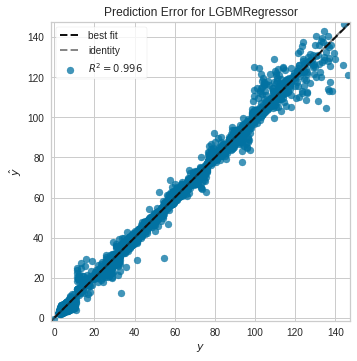

In [35]:
plot_model(tuned_model, plot = 'error')

### __Curva de Aprendizado__

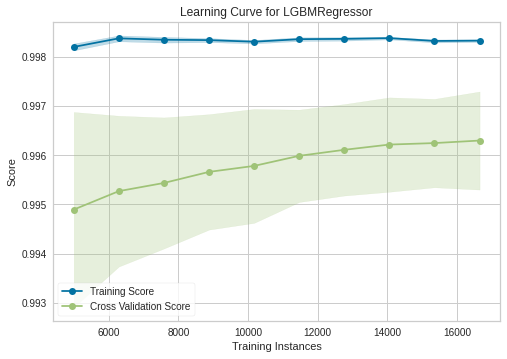

In [36]:
plot_model(tuned_model, plot = 'learning')

### __Curva de Validação__

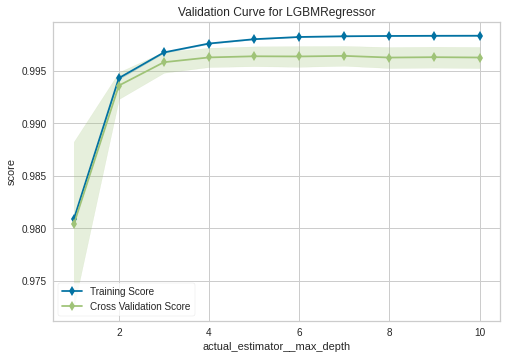

In [37]:
plot_model(tuned_model, plot = 'vc')

### __Importância de Atributos__

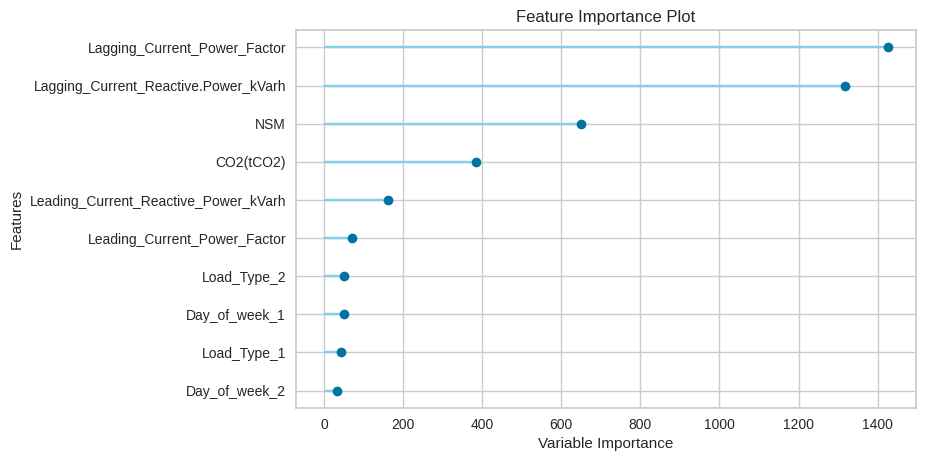

In [39]:
plot_model(tuned_model, plot = 'feature')

## __Finalizando o Modelo__

In [40]:
finalized_model = finalize_model(tuned_model)

### __Fazendo predição com dados de validação do PyCaret__

In [41]:
predicted = predict_model(finalized_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.698,1.9825,1.408,0.9982,0.0899,0.0584


### __Avaliando o resultado com dados de teste__

Usamos dados de teste para validar o modelo com 10 execuções utilizando a métrica RMSE

In [81]:
rs = ShuffleSplit(n_splits=10, test_size=0.20, random_state=int(np.random.rand()*100))
RMSE_list = []
for train_index, test_index in rs.split(test):
  test_data = test.iloc[test_index,:].copy()
  predicted = predict_model(finalized_model, data=test_data)
  predict_model(finalized_model, data=test_data)
  RMSE = mean_squared_error(predicted.Usage_kWh.values, predicted.Label.values, squared=False)
  print(f'{RMSE:.3f}')
  RMSE_list.append(RMSE)

print(f"RMSE Média:{np.mean(RMSE_list):.3f} +/- {np.std(RMSE_list):.3f}")

2.030
1.944
1.981
2.238
2.159
1.961
2.090
1.940
1.747
1.920
RMSE Média:2.001 +/- 0.130
